#**Практическое задание №1**

Установка необходимых пакетов:

In [3]:
!pip install -q tqdm
!pip install --upgrade --no-cache-dir gdown

Монтирование Вашего Google Drive к текущему окружению:

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Константы, которые пригодятся в коде далее, и ссылки (gdrive идентификаторы) на предоставляемые наборы данных:

In [46]:
EVALUATE_ONLY = False
TEST_ON_LARGE_DATASET = True
PROJECT_DIR = '/content/drive/MyDrive/'
TISSUE_CLASSES = ('ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM')
DATASETS_LINKS = {
    'train': '16ljuhaPfmjE2Nnsa9H4ndvXN-5Yu4oVj',
    'train_small': '1qd45xXfDwdZjktLFwQb-et-mAaFeCzOR',
    'train_tiny': '1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui',
    'test': '1Ij785V4snC5VaDY_Pc5hKidW0johHggk',
    'test_small': '1wbRsog0n7uGlHIPGLhyN-PMeT2kdQ2lI',
    'test_tiny': '1viiB0s041CNsAK4itvX8PnYthJ-MDnQc'
}

Импорт необходимых зависимостей:

In [40]:
from pathlib import Path
import numpy as np
from typing import List
from tqdm.notebook import tqdm
from time import sleep
from PIL import Image
import IPython.display
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report
import gdown
from typing import List
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
import gc
import os
import time
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

---
### Класс Dataset

Предназначен для работы с наборами данных, обеспечивает чтение изображений и соответствующих меток, а также формирование пакетов (батчей).

In [7]:
class Dataset:

    def __init__(self, name):
        self.name = name
        self.is_loaded = False
        url = f"https://drive.google.com/uc?export=download&confirm=pbef&id={DATASETS_LINKS[name]}"
        output = f'{name}.npz'
        gdown.download(url, output, quiet=False)
        print(f'Loading dataset {self.name} from npz.')
        np_obj = np.load(f'{name}.npz')
        self.images = np_obj['data']
        self.labels = np_obj['labels']
        self.n_files = self.images.shape[0]
        self.is_loaded = True
        print(f'Done. Dataset {name} consists of {self.n_files} images.')

    def image(self, i):
        # read i-th image in dataset and return it as numpy array
        if self.is_loaded:
            return self.images[i, :, :, :]

    def images_seq(self, n=None):
        # sequential access to images inside dataset (is needed for testing)
        for i in range(self.n_files if not n else n):
            yield self.image(i)

    def random_image_with_label(self):
        # get random image with label from dataset
        i = np.random.randint(self.n_files)
        return self.image(i), self.labels[i]

    def random_batch_with_labels(self, n):
        # create random batch of images with labels (is needed for training)
        indices = np.random.choice(self.n_files, n)
        imgs = []
        for i in indices:
            img = self.image(i)
            imgs.append(self.image(i))
        logits = np.array([self.labels[i] for i in indices])
        return np.stack(imgs), logits

    def image_with_label(self, i: int):
        # return i-th image with label from dataset
        return self.image(i), self.labels[i]

### Пример использвания класса Dataset
Загрузим обучающий набор данных, получим произвольное изображение с меткой. После чего визуализируем изображение, выведем метку. В будущем, этот кусок кода можно закомментировать или убрать.

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui
To: /content/train_tiny.npz
100%|██████████| 105M/105M [00:00<00:00, 130MB/s] 


Loading dataset train_tiny from npz.
Done. Dataset train_tiny consists of 900 images.

Got numpy array of shape (224, 224, 3), and label with code 2.
Label code corresponds to DEB class.


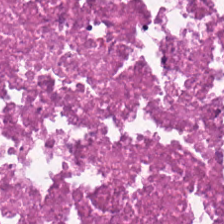

In [8]:
d_train_tiny = Dataset('train_tiny')

img, lbl = d_train_tiny.random_image_with_label()
print()
print(f'Got numpy array of shape {img.shape}, and label with code {lbl}.')
print(f'Label code corresponds to {TISSUE_CLASSES[lbl]} class.')

pil_img = Image.fromarray(img)
IPython.display.display(pil_img)

### Обёртка над Dataset для использования с PyTorch

In [43]:
# ============================================================
# (Опционально) Обёртка над Dataset для использования с PyTorch
# ============================================================

# ВНИМАНИЕ:
# Этот код нужен только тем, кто хочет решать задание с помощью PyTorch.
# Он показывает, как "подключить" наш Dataset к torch.utils.data.DataLoader.
'''
try:
    import torch
    from torch.utils.data import Dataset as TorchDataset, DataLoader
    import torchvision.transforms as T
    from PIL import Image

    class HistologyTorchDataset(TorchDataset):
        """
        Обёртка над Dataset для использования с PyTorch.

        base_dataset: экземпляр Dataset('train'), Dataset('train_small'), etc.
        transform:    функция/объект, преобразующий изображение (PIL.Image -> torch.Tensor).

        """
        def __init__(self, base_dataset, transform=None):
            self.base = base_dataset
            # Минимальный transform по умолчанию:
            # np.uint8 [0, 255] -> float32 [0.0, 1.0]
            self.transform = transform or T.ToTensor()

        def __len__(self):
            # Размер датасета
            return len(self.base.images)

        def __getitem__(self, idx):
            """
            Возвращает (image_tensor, label) для PyTorch.
            image_tensor: torch.Tensor формы [3, H, W]
            label: int
            """
            img, label = self.base.image_with_label(idx)  # img: np.ndarray (H, W, 3)
            img = Image.fromarray(img)                    # в PIL.Image
            img = self.transform(img)                     # в torch.Tensor
            return img, label

except ImportError:
    HistologyTorchDataset = None
    print("PyTorch / torchvision не найдены. Обёртка HistologyTorchDataset недоступна.")
    '''

KeyboardInterrupt: 

### Пример использвания класса HistologyTorchDataset

In [8]:
'''if "HistologyTorchDataset" not in globals() or HistologyTorchDataset is None:
    print("PyTorch не установлен или обёртка недоступна — пример пропущен.")
else:
    print("Пример использования PyTorch-обёртки над Dataset")

    base_train = Dataset('train_tiny')

    # Создаём PyTorch-совместимый датасет
    train_ds = HistologyTorchDataset(base_train)

    # DataLoader автоматически создаёт батчи и перемешивает данные
    from torch.utils.data import DataLoader
    train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)

    # Берём один батч и выводим информацию
    images_batch, labels_batch = next(iter(train_loader))

    print("Форма батча изображений:", tuple(images_batch.shape))  # [batch, 3, 224, 224]
    print("Форма батча меток:", tuple(labels_batch.shape))        # [batch]
    print("Пример меток:", labels_batch[:10].tolist())

    print("Тип images_batch:", type(images_batch))
    print("Тип labels_batch:", type(labels_batch))
'''

Пример использования PyTorch-обёртки над Dataset


Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui
To: /content/train_tiny.npz
100%|██████████| 105M/105M [00:00<00:00, 111MB/s] 


Loading dataset train_tiny from npz.
Done. Dataset train_tiny consists of 900 images.
Форма батча изображений: (8, 3, 224, 224)
Форма батча меток: (8,)
Пример меток: [0, 7, 6, 6, 1, 3, 3, 3]
Тип images_batch: <class 'torch.Tensor'>
Тип labels_batch: <class 'torch.Tensor'>


---
### Класс Metrics

Реализует метрики точности, используемые для оценивания модели:
1. точность,
2. сбалансированную точность.

In [9]:
class Metrics:

    @staticmethod
    def accuracy(gt: List[int], pred: List[int]):
        assert len(gt) == len(pred), 'gt and prediction should be of equal length'
        return sum(int(i[0] == i[1]) for i in zip(gt, pred)) / len(gt)

    @staticmethod
    def accuracy_balanced(gt: List[int], pred: List[int]):
        return balanced_accuracy_score(gt, pred)

    @staticmethod
    def print_all(gt: List[int], pred: List[int], info: str):
        print(f'metrics for {info}:')
        print('\t accuracy {:.4f}:'.format(Metrics.accuracy(gt, pred)))
        print('\t balanced accuracy {:.4f}:'.format(Metrics.accuracy_balanced(gt, pred)))

---
### Класс Model

Класс, хранящий в себе всю информацию о модели.

Вам необходимо реализовать методы save, load для сохранения и заргрузки модели. Особенно актуально это будет во время тестирования на дополнительных наборах данных.

> *Пожалуйста, убедитесь, что сохранение и загрузка модели работает корректно. Для этого обучите модель, протестируйте, сохраните ее в файл, перезапустите среду выполнения, загрузите обученную модель из файла, вновь протестируйте ее на тестовой выборке и убедитесь в том, что получаемые метрики совпадают с полученными для тестовой выбрки ранее.*


Также, Вы можете реализовать дополнительные функции, такие как:
1. валидацию модели на части обучающей выборки;
2. использование кроссвалидации;
3. автоматическое сохранение модели при обучении;
4. загрузку модели с какой-то конкретной итерации обучения (если используется итеративное обучение);
5. вывод различных показателей в процессе обучения (например, значение функции потерь на каждой эпохе);
6. построение графиков, визуализирующих процесс обучения (например, график зависимости функции потерь от номера эпохи обучения);
7. автоматическое тестирование на тестовом наборе/наборах данных после каждой эпохи обучения (при использовании итеративного обучения);
8. автоматический выбор гиперпараметров модели во время обучения;
9. сохранение и визуализацию результатов тестирования;
10. Использование аугментации и других способов синтетического расширения набора данных (дополнительным плюсом будет обоснование необходимости и обоснование выбора конкретных типов аугментации)
11. и т.д.

Полный список опций и дополнений приведен в презентации с описанием задания.

При реализации дополнительных функций допускается добавление параметров в существующие методы и добавление новых методов в класс модели.

In [44]:
class Model:
    def __init__(self, n_folds=3, use_pca=True):
        self.model = None
        self.scaler = StandardScaler()
        self.pca = None
        self.use_pca = use_pca
        self.classes = TISSUE_CLASSES
        self.n_folds = n_folds
        self.history = []
        self.feature_selector = None
        self.feature_names = []
        self.original_feature_dim = None

    def save(self, name: str):
        if self.model is None:
            print("Модель-пустышка, что-то сделайте с ней")
            return

        model_data = {
            'model': self.model,
            'scaler': self.scaler,
            'pca': self.pca,
            'use_pca': self.use_pca,
            'history': self.history,
            'classes': self.classes,
            'feature_names': self.feature_names,
            'original_feature_dim': self.original_feature_dim
        }

        save_path = os.path.join(PROJECT_DIR, f'{name}.joblib')
        joblib.dump(model_data, save_path)
        print(f"Модель cохранили в {save_path}")

    def load(self, name: str):
        try:
            load_path = os.path.join(PROJECT_DIR, f'{name}.joblib')
            if os.path.exists(load_path):
                model_data = joblib.load(load_path)
            else:
                model_data = joblib.load(f'{name}.joblib')

            self.model = model_data['model']
            self.scaler = model_data['scaler']
            self.pca = model_data.get('pca')
            self.use_pca = model_data.get('use_pca', True)
            self.history = model_data.get('history', [])
            self.classes = model_data.get('classes', self.classes)
            self.feature_names = model_data.get('feature_names', [])
            self.original_feature_dim = model_data.get('original_feature_dim')
            print(f"Модель {name} з")

        except Exception as e:
            print(f"Беда с загрузкой модели: {e}")
            self.__init__()

    def extract_features(self, img):
    #самые простые признаки: яркость (разные ткани по-разному подсвечены),
    #разброс яркости, энтропия (=> сложные структуры, то есть не жировая ткань)
    #модуль градиента показывает контраст переходов между тканями
        img_normalized = img / 255.0 #к [0, 1]

        features = []

        for ch, color in enumerate(['R', 'G', 'B']):
            channel_data = img_normalized[:, :, ch]
            flat_channel = channel_data.flatten()

            features.extend([
                np.mean(channel_data),
                np.std(channel_data),
                np.percentile(flat_channel, 25),
                np.percentile(flat_channel, 50),
                np.percentile(flat_channel, 75),
                np.max(channel_data),
                np.min(channel_data),
                np.mean(np.abs(channel_data - np.mean(channel_data))),
                np.var(channel_data),
                np.sum(channel_data > 0.5) / channel_data.size,
                np.sum(channel_data < 0.3) / channel_data.size,
            ])

        gray = np.mean(img_normalized, axis=2)
        grad_x = np.abs(np.gradient(gray, axis=0))
        grad_y = np.abs(np.gradient(gray, axis=1))

        features.extend([
            np.mean(grad_x), np.std(grad_x),
            np.mean(grad_y), np.std(grad_y),
            np.mean(np.sqrt(grad_x**2 + grad_y**2)),
            np.std(np.sqrt(grad_x**2 + grad_y**2)),
        ])

        features.extend([
            np.mean(img_normalized[:, :, 0]),
            np.mean(img_normalized[:, :, 1]),
            np.mean(img_normalized[:, :, 2]),
        ])

        r_g_ratio = np.mean(img_normalized[:, :, 0]) / (np.mean(img_normalized[:, :, 1]) + 1e-10)
        r_b_ratio = np.mean(img_normalized[:, :, 0]) / (np.mean(img_normalized[:, :, 2]) + 1e-10)
        g_b_ratio = np.mean(img_normalized[:, :, 1]) / (np.mean(img_normalized[:, :, 2]) + 1e-10)

        features.extend([r_g_ratio, r_b_ratio, g_b_ratio])

        for ch in range(3):
            hist, _ = np.histogram(img_normalized[:, :, ch].flatten(), bins=5, range=(0, 1))
            features.extend(hist / hist.sum())

        points = [(56, 56), (56, 168), (168, 56), (168, 168)] #текстуры по краям
        for idx, (x, y) in enumerate(points):
            patch = gray[max(0, x-1):min(224, x+2), max(0, y-1):min(224, y+2)]
            if patch.size > 0:
                features.append(np.std(patch))
            else:
                features.append(0)

        hist_gray, _ = np.histogram(gray.flatten(), bins=20, density=True)
        hist_gray = hist_gray[hist_gray > 0]
        entropy = -np.sum(hist_gray * np.log2(hist_gray))
        features.append(entropy)

        return np.array(features, dtype=np.float32)

    def process_dataset_chunked(self, dataset, limit=None, chunk_size=500):
        n = dataset.n_files if not limit else int(dataset.n_files * limit)

        sample_img = dataset.image(0)
        sample_features = self.extract_features(sample_img)
        feature_dim = len(sample_features)
        self.original_feature_dim = feature_dim

        X = np.zeros((n, feature_dim), dtype=np.float32)
        y = np.zeros(n, dtype=np.int32)

        for start_idx in tqdm(range(0, n, chunk_size), desc="Извлечение признаков"):
            end_idx = min(start_idx + chunk_size, n)

            for i in range(start_idx, end_idx):
                img = dataset.image(i)
                X[i] = self.extract_features(img)
                y[i] = dataset.labels[i]

            if start_idx % (chunk_size * 5) == 0:
                gc.collect()

        return X, y

    def visualize_data(self, X_train, y_train, X_val, y_val):
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        train_counts = np.bincount(y_train)
        axes[0, 0].bar(range(len(self.classes)), train_counts, color='skyblue', alpha=0.7, label='Train')
        val_counts = np.bincount(y_val)
        axes[0, 0].bar(range(len(self.classes)), val_counts, color='lightcoral', alpha=0.7, label='Val')
        axes[0, 0].set_title('Распределение классов', fontsize=12)
        axes[0, 0].set_xlabel('Класс', fontsize=10)
        axes[0, 0].set_ylabel('Количество', fontsize=10)
        axes[0, 0].set_xticks(range(len(self.classes)))
        axes[0, 0].set_xticklabels(self.classes, rotation=45, fontsize=9)
        axes[0, 0].legend()
        plt.show()

    def train(self, dataset: Dataset):
        print(f'Обучение на датасете {dataset.name}\n\n')

        start_time = time.time()

        X, y = self.process_dataset_chunked(dataset, chunk_size=300)

        print(f"Количество образцов: {X.shape[0]}")
        print(f"Количество признаков: {X.shape[1]}")
        print(f"Количество классов: {len(np.unique(y))}")

        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        del X, y
        gc.collect()

        print(f"Тренировочные: {X_train.shape[0]} образцов")
        print(f"Валидационные: {X_val.shape[0]} образцов")

        X_train_scaled = self.scaler.fit_transform(X_train)
        X_val_scaled = self.scaler.transform(X_val)

        param_grid = {
            'n_estimators': [50, 100],
            'max_depth': [10, 15, 20],
            'min_samples_split': [2, 5]
        }

        best_score = 0
        best_params = None
        best_model = None

        for n_est in param_grid['n_estimators']:
            for depth in param_grid['max_depth']:
                for min_split in param_grid['min_samples_split']:
                    model = RandomForestClassifier(
                        n_estimators=n_est,
                        max_depth=depth,
                        min_samples_split=min_split,
                        min_samples_leaf=2,
                        random_state=42,
                        n_jobs=-1,
                        class_weight='balanced'
                    )

                    try:
                        scores = cross_val_score(model, X_train_scaled, y_train,
                                               cv=min(3, len(np.unique(y_train))),
                                               scoring='balanced_accuracy',
                                               n_jobs=-1)
                        mean_score = np.mean(scores)

                        if mean_score > best_score:
                            best_score = mean_score
                            best_params = (n_est, depth, min_split)
                            best_model = model
                    except Exception as e:
                        continue

        if best_model is None:
            best_model = RandomForestClassifier( #просто нам сегодня на лекции
                #рассказали, что случайный лес - очень самый метод
                #среди классических из ML
                n_estimators=100,
                max_depth=15,
                min_samples_split=5,
                min_samples_leaf=2,
                random_state=42,
                n_jobs=-1,
                class_weight='balanced'
            )
            best_params = (100, 15, 5)

        print(f"Лучшие параметры: n_est={best_params[0]}, depth={best_params[1]}, min_split={best_params[2]}")
        print(f"Лучший CV score: {best_score:.4f}")

        self.model = best_model
        self.model.fit(X_train_scaled, y_train)

        y_val_pred = self.model.predict(X_val_scaled)
        val_accuracy = Metrics.accuracy(y_val, y_val_pred)
        val_balanced_accuracy = Metrics.accuracy_balanced(y_val, y_val_pred)

        print("РЕЗУЛЬТАТЫ НА ВАЛИДАЦИИ\n\n")
        print(f"Accuracy: {val_accuracy:.4f}")
        print(f"Balanced Accuracy: {val_balanced_accuracy:.4f}")

        self.visualize_data(X_train, y_train, X_val, y_val)
        self.plot_confusion_matrix(y_val, y_val_pred, "Validation Set")

        self.history.append({
            'val_accuracy': val_accuracy,
            'val_balanced_accuracy': val_balanced_accuracy,
            'best_params': best_params,
            'best_cv_score': best_score,
            'training_time': time.time() - start_time,
            'n_features': X_train_scaled.shape[1],
            'n_samples': X_train_scaled.shape[0]
        })

        training_time = time.time() - start_time
        print(f"\nОбучение завершено за {training_time:.2f} секунд)")

    def plot_confusion_matrix(self, y_true, y_pred, title):
        cm = confusion_matrix(y_true, y_pred)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
                   xticklabels=self.classes,
                   yticklabels=self.classes)
        ax1.set_title(f'Confusion Matrix - {title}', fontsize=14)
        ax1.set_xlabel('Predicted', fontsize=12)
        ax1.set_ylabel('True', fontsize=12)

        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', ax=ax2,
                   xticklabels=self.classes,
                   yticklabels=self.classes)
        ax2.set_title(f'Normalized Confusion Matrix - {title}', fontsize=14)
        ax2.set_xlabel('Predicted', fontsize=12)
        ax2.set_ylabel('True', fontsize=12)

        plt.tight_layout()
        plt.savefig(f'confusion_matrix_{title.replace(" ", "_")}.png',
                   dpi=100, bbox_inches='tight')
        plt.show()

        print("\nАНАЛИЗ ОШИБОК:")
        for i, true_class in enumerate(self.classes):
            total = cm[i, :].sum()
            correct = cm[i, i]
            accuracy = correct / total if total > 0 else 0

            errors = []
            for j, pred_class in enumerate(self.classes):
                if i != j and cm[i, j] > 0:
                    error_rate = cm[i, j] / total
                    errors.append((pred_class, cm[i, j], error_rate))

            errors.sort(key=lambda x: x[1], reverse=True)

            if len(errors) > 0:
                print(f"\n{true_class}: {accuracy:.1%} точность")
                for pred_class, count, rate in errors[:3]:
                    print(f"  Часто путают с {pred_class}: {count} раз ({rate:.1%})")

    def test_on_dataset(self, dataset: Dataset, limit=None):
      n = dataset.n_files if not limit else int(dataset.n_files * limit)
      predictions = []

      pbar = tqdm(total=n, desc="Тестирование")

      for i in range(n):
          img = dataset.image(i)
          pred = self.test_on_image(img)
          predictions.append(pred)

          pbar.update(1)

          if i % 100 == 0:
              gc.collect()

      pbar.close()

      return predictions

    def test_on_image(self, img: np.ndarray):
        if self.model is None:
            return np.random.randint(9)

        features = self.extract_features(img)
        features_scaled = self.scaler.transform(features.reshape(1, -1))

        if self.use_pca and self.pca is not None:
            if features_scaled.shape[1] != self.pca.n_components_:
                features_scaled = self.pca.transform(features_scaled)

        prediction = self.model.predict(features_scaled)
        return int(prediction[0])

    def visualize_predictions(self, dataset: Dataset, n_samples=9):
        fig, axes = plt.subplots(3, 3, figsize=(15, 12))
        axes = axes.ravel()

        samples_collected = 0
        attempts = 0
        max_attempts = n_samples * 5

        while samples_collected < n_samples and attempts < max_attempts:
            idx = np.random.randint(dataset.n_files)
            img, true_label = dataset.image_with_label(idx)
            pred_label = self.test_on_image(img)

            if samples_collected < 3 or true_label != pred_label or attempts > n_samples * 2:
                ax = axes[samples_collected]
                ax.imshow(img)

                color = 'green' if true_label == pred_label else 'red'
                ax.set_title(f'True: {self.classes[true_label]}\nPred: {self.classes[pred_label]}',
                           color=color, fontsize=11, pad=10)
                ax.axis('off')

                for spine in ax.spines.values():
                    spine.set_color(color)
                    spine.set_linewidth(3)

                samples_collected += 1

            attempts += 1

        for i in range(samples_collected, n_samples):
            axes[i].axis('off')
            axes[i].set_title('Нет данных', fontsize=11)

        plt.suptitle('Примеры предсказаний модели', fontsize=14, y=1.02)
        plt.tight_layout()
        plt.savefig('predictions_visualization.png', dpi=100, bbox_inches='tight')
        plt.show()

---
### Классификация изображений

Используя введенные выше классы можем перейти уже непосредственно к обучению модели классификации изображений. Пример общего пайплайна решения задачи приведен ниже. Вы можете его расширять и улучшать. В данном примере используются наборы данных 'train_small' и 'test_small'.

In [47]:
d_train = Dataset('train')
d_test = Dataset('test')

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=16ljuhaPfmjE2Nnsa9H4ndvXN-5Yu4oVj
To: /content/train.npz
100%|██████████| 2.10G/2.10G [00:34<00:00, 60.9MB/s]


Loading dataset train from npz.
Done. Dataset train consists of 18000 images.


Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1Ij785V4snC5VaDY_Pc5hKidW0johHggk
To: /content/test.npz
100%|██████████| 525M/525M [00:11<00:00, 46.0MB/s]


Loading dataset test from npz.
Done. Dataset test consists of 4500 images.


Обучение на датасете train




Извлечение признаков: 100%|██████████| 60/60 [04:56<00:00,  4.94s/it]

Количество образцов: 18000
Количество признаков: 65
Количество классов: 9
Тренировочные: 14400 образцов
Валидационные: 3600 образцов


Лучшие параметры: n_est=100, depth=20, min_split=5
Лучший CV score: 0.8804
РЕЗУЛЬТАТЫ НА ВАЛИДАЦИИ


Accuracy: 0.8919
Balanced Accuracy: 0.8919


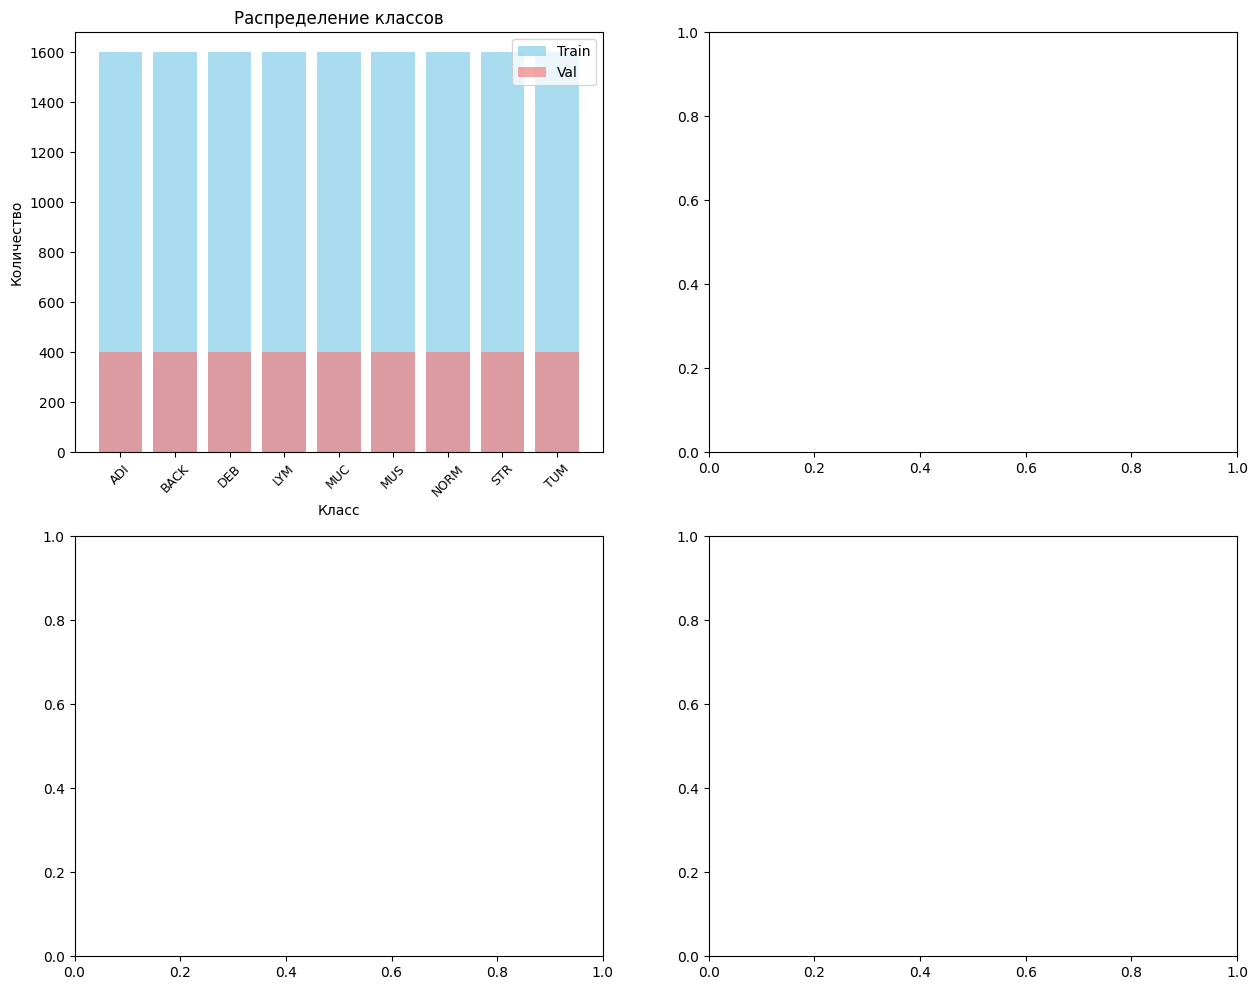

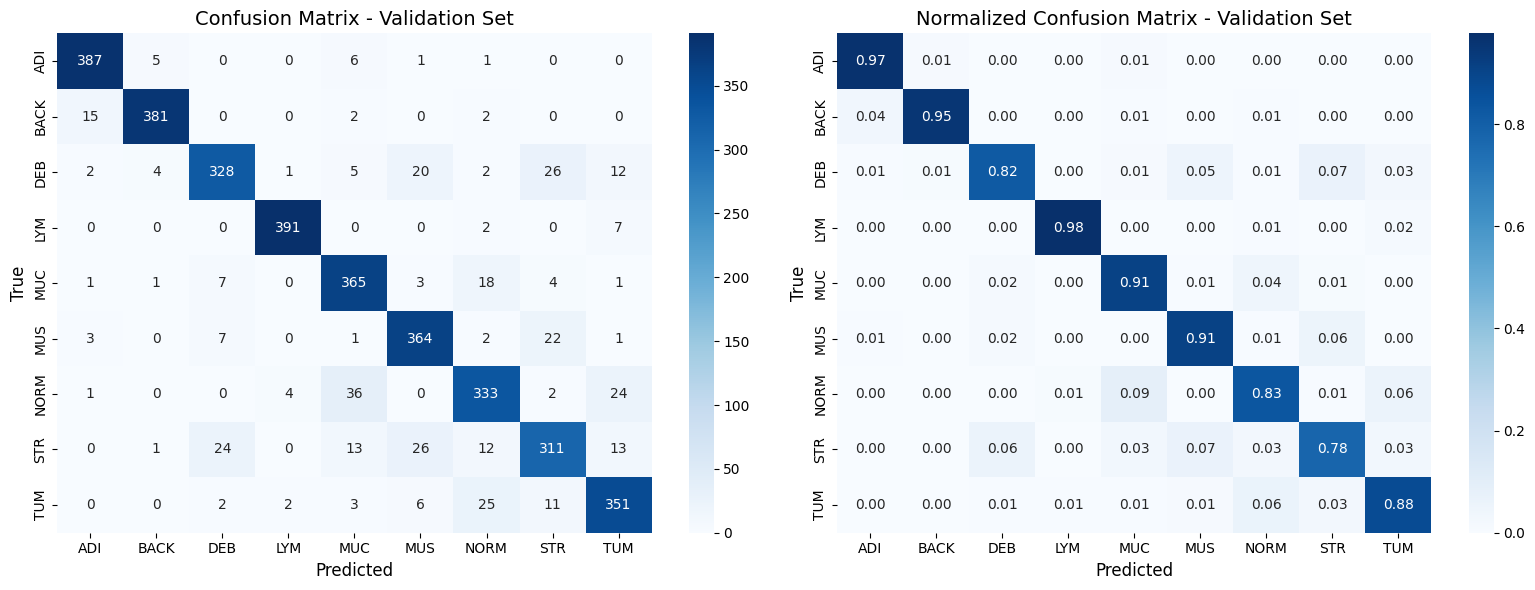


АНАЛИЗ ОШИБОК:

ADI: 96.8% точность
  Часто путают с MUC: 6 раз (1.5%)
  Часто путают с BACK: 5 раз (1.2%)
  Часто путают с MUS: 1 раз (0.2%)

BACK: 95.2% точность
  Часто путают с ADI: 15 раз (3.8%)
  Часто путают с MUC: 2 раз (0.5%)
  Часто путают с NORM: 2 раз (0.5%)

DEB: 82.0% точность
  Часто путают с STR: 26 раз (6.5%)
  Часто путают с MUS: 20 раз (5.0%)
  Часто путают с TUM: 12 раз (3.0%)

LYM: 97.8% точность
  Часто путают с TUM: 7 раз (1.8%)
  Часто путают с NORM: 2 раз (0.5%)

MUC: 91.2% точность
  Часто путают с NORM: 18 раз (4.5%)
  Часто путают с DEB: 7 раз (1.8%)
  Часто путают с STR: 4 раз (1.0%)

MUS: 91.0% точность
  Часто путают с STR: 22 раз (5.5%)
  Часто путают с DEB: 7 раз (1.8%)
  Часто путают с ADI: 3 раз (0.8%)

NORM: 83.2% точность
  Часто путают с MUC: 36 раз (9.0%)
  Часто путают с TUM: 24 раз (6.0%)
  Часто путают с LYM: 4 раз (1.0%)

STR: 77.8% точность
  Часто путают с MUS: 26 раз (6.5%)
  Часто путают с DEB: 24 раз (6.0%)
  Часто путают с MUC: 13 раз (

In [48]:
model = Model()
if not EVALUATE_ONLY:
    model.train(d_train)
    model.save('best')
else:
    model.load('best')

Пример тестирования модели на части набора данных:

In [49]:
# evaluating model on 10% of test dataset
pred_1 = model.test_on_dataset(d_test, limit=0.1)
Metrics.print_all(d_test.labels[:len(pred_1)], pred_1, '10% of test')

Тестирование: 100%|██████████| 450/450 [00:19<00:00, 23.63it/s]

metrics for 10% of test:
	 accuracy 0.9756:
	 balanced accuracy 0.9756:


Пример тестирования модели на полном наборе данных:

In [50]:
# evaluating model on full test dataset (may take time)
if TEST_ON_LARGE_DATASET:
    pred_2 = model.test_on_dataset(d_test)
    Metrics.print_all(d_test.labels, pred_2, 'test')

Тестирование: 100%|██████████| 4500/4500 [03:11<00:00, 23.49it/s]


metrics for test:
	 accuracy 0.8838:
	 balanced accuracy 0.8838:


Результат работы пайплайна обучения и тестирования выше тоже будет оцениваться. Поэтому не забудьте присылать на проверку ноутбук с выполнеными ячейками кода с демонстрациями метрик обучения, графиками и т.п. В этом пайплайне Вам необходимо продемонстрировать работу всех реализованных дополнений, улучшений и т.п.

<font color="red">
Настоятельно рекомендуется после получения пайплайна с полными результатами обучения экспортировать ноутбук в pdf (файл -> печать) и прислать этот pdf вместе с самим ноутбуком.
</font>

### Тестирование модели на других наборах данных

Ваша модель должна поддерживать тестирование на других наборах данных. Для удобства, Вам предоставляется набор данных test_tiny, который представляет собой малую часть (2% изображений) набора test. Ниже приведен фрагмент кода, который будет осуществлять тестирование для оценивания Вашей модели на дополнительных тестовых наборах данных.

<font color="red">
Прежде чем отсылать задание на проверку, убедитесь в работоспособности фрагмента кода ниже.
</font>

In [51]:
final_model = Model()
final_model.load('best')
d_test_tiny = Dataset('test_tiny')
pred = final_model.test_on_dataset(d_test_tiny)
Metrics.print_all(d_test_tiny.labels, pred, 'test-tiny')

Модель best з


Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1viiB0s041CNsAK4itvX8PnYthJ-MDnQc
To: /content/test_tiny.npz
100%|██████████| 10.6M/10.6M [00:00<00:00, 52.3MB/s]


Loading dataset test_tiny from npz.
Done. Dataset test_tiny consists of 90 images.


Тестирование: 100%|██████████| 90/90 [00:03<00:00, 23.82it/s]

metrics for test-tiny:
	 accuracy 0.8333:
	 balanced accuracy 0.8333:


Отмонтировать Google Drive.

In [52]:
drive.flush_and_unmount()

---
# Дополнительные "полезности"

Ниже приведены примеры использования различных функций и библиотек, которые могут быть полезны при выполнении данного практического задания.

### Измерение времени работы кода

Измерять время работы какой-либо функции можно легко и непринужденно при помощи функции timeit из соответствующего модуля:

In [ ]:
import timeit

def factorial(n):
    res = 1
    for i in range(1, n + 1):
        res *= i
    return res


def f():
    return factorial(n=1000)

n_runs = 128
print(f'Function f is caluclated {n_runs} times in {timeit.timeit(f, number=n_runs)}s.')

### Scikit-learn

Для использования "классических" алгоритмов машинного обучения рекомендуется использовать библиотеку scikit-learn (https://scikit-learn.org/stable/). Пример классификации изображений цифр из набора данных MNIST при помощи классификатора SVM:

In [ ]:
# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# The digits dataset
digits = datasets.load_digits()

# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.
_, axes = plt.subplots(2, 4)
images_and_labels = list(zip(digits.images, digits.target))
for ax, (image, label) in zip(axes[0, :], images_and_labels[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Create a classifier: a support vector classifier
classifier = svm.SVC(gamma=0.001)

# Split data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False)

# We learn the digits on the first half of the digits
classifier.fit(X_train, y_train)

# Now predict the value of the digit on the second half:
predicted = classifier.predict(X_test)

images_and_predictions = list(zip(digits.images[n_samples // 2:], predicted))
for ax, (image, prediction) in zip(axes[1, :], images_and_predictions[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Prediction: %i' % prediction)

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(y_test, predicted)))

# Матрица ошибок + визуализация в новом API
cm = metrics.confusion_matrix(y_test, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classifier.classes_)

fig, ax = plt.subplots(figsize=(4, 4))
disp.plot(ax=ax)
ax.set_title("Confusion Matrix")
plt.tight_layout()
plt.show()

### Scikit-image

Реализовывать различные операции для работы с изображениями можно как самостоятельно, работая с массивами numpy, так и используя специализированные библиотеки, например, scikit-image (https://scikit-image.org/). Ниже приведен пример использования Canny edge detector.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature


# Generate noisy image of a square
im = np.zeros((128, 128))
im[32:-32, 32:-32] = 1

im = ndi.rotate(im, 15, mode='constant')
im = ndi.gaussian_filter(im, 4)
im += 0.2 * np.random.random(im.shape)

# Compute the Canny filter for two values of sigma
edges1 = feature.canny(im)
edges2 = feature.canny(im, sigma=3)

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.imshow(im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('noisy image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title(r'Canny filter, $\sigma=3$', fontsize=20)

fig.tight_layout()

plt.show()

### Tensorflow 2

Для создания и обучения нейросетевых моделей можно использовать фреймворк глубокого обучения Tensorflow 2. Ниже приведен пример простейшей нейроной сети, использующейся для классификации изображений из набора данных MNIST.

In [ ]:
# Install TensorFlow

import tensorflow as tf

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)

model.evaluate(x_test,  y_test, verbose=2)

<font color="red">
Для эффективной работы с моделями глубокого обучения убедитесь в том, что в текущей среде Google Colab используется аппаратный ускоритель GPU или TPU. Для смены среды выберите "среда выполнения" -> "сменить среду выполнения".
</font>

Большое количество туториалов и примеров с кодом на Tensorflow 2 можно найти на официальном сайте https://www.tensorflow.org/tutorials?hl=ru.

Также, Вам может понадобиться написать собственный генератор данных для Tensorflow 2. Скорее всего он будет достаточно простым, и его легко можно будет реализовать, используя официальную документацию TensorFlow 2. Но, на всякий случай (если не удлось сразу разобраться или хочется вникнуть в тему более глубоко), можете посмотреть следующий отличный туториал: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.

### PyTorch

In [ ]:
# ============================================================
# Дополнительно: мини-демо PyTorch
# ============================================================
# Ранний выход, если PyTorch/обёртка недоступны
try:
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    from torch.utils.data import DataLoader
except ImportError:
    print("PyTorch не установлен — демо пропущено.")
    import sys
    raise SystemExit

if "HistologyTorchDataset" not in globals() or HistologyTorchDataset is None:
    print("HistologyTorchDataset недоступна — демо пропущено.")
    import sys
    raise SystemExit


# --- Данные: tiny-наборы, чтобы выполнялось быстро ---
base_train = Dataset('train_tiny')
base_test  = Dataset('test_tiny')

train_ds = HistologyTorchDataset(base_train)           # ToTensor по умолчанию
test_ds  = HistologyTorchDataset(base_test)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False)

# --- Мини-модель: двухслойный CNN + один FC (демонстрация, не решение) ---
class TinyCNN(nn.Module):
    def __init__(self, num_classes=len(TISSUE_CLASSES)):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)  # 224->112->56
        self.fc    = nn.Linear(16 * 56 * 56, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B, 3, 224, 224] -> [B, 8, 112, 112]
        x = self.pool(F.relu(self.conv2(x)))  # [B, 8, 112, 112] -> [B, 16, 56, 56]
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = TinyCNN(num_classes=len(TISSUE_CLASSES)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# --- Один учебный шаг "обучения" на одном батче ---
model.train()
xb, yb = next(iter(train_loader))
xb = xb.to(device)
yb = yb.to(device, dtype=torch.long)

optimizer.zero_grad()
logits = model(xb)
loss = criterion(logits, yb)
float_loss = float(loss.detach().cpu())
loss.backward()
optimizer.step()

print(f"Loss на одном батче train_tiny: {float_loss:.4f}")

# --- Быстрая проверка на одном батче теста (для формы вывода/метрик) ---
model.eval()
with torch.no_grad():
    xt, yt = next(iter(test_loader))
    xt = xt.to(device)
    logits_t = model(xt).cpu()
    y_pred = logits_t.argmax(dim=1).numpy()
    y_true = yt.numpy()

print("Размерности:", {"y_true": y_true.shape, "y_pred": y_pred.shape})
Metrics.print_all(y_true, y_pred, "_")  # balanced accuracy/accuracy на одном батче для демонстрации

# для полноценного решения требуется собственный тренировочный цикл по эпохам,
# аугментации/нормализация, сохранение/загрузка весов, и тестирование на всём наборе.

### Дополнительные ресурсы по PyTorch

- **Официальные туториалы PyTorch** — https://pytorch.org/tutorials/  
- **“Deep Learning with PyTorch: 60-Minute Blitz”** — https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
- **Transfer Learning for Computer Vision** — https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html  
- **PyTorch Get Started (установка)** — https://pytorch.org/get-started/locally/  
- **Dive into Deep Learning (D2L, глава PyTorch)** — https://d2l.ai/chapter_preliminaries/index.html  
- **Fast.ai — Practical Deep Learning for Coders** — https://course.fast.ai/  
- **Learn PyTorch.io (Zero to Mastery)** — https://www.learnpytorch.io/

### Numba

В некоторых ситуациях, при ручных реализациях графовых алгоритмов, выполнение многократных вложенных циклов for в python можно существенно ускорить, используя JIT-компилятор Numba (https://numba.pydata.org/).
Примеры использования Numba в Google Colab можно найти тут:
1. https://colab.research.google.com/github/cbernet/maldives/blob/master/numba/numba_cuda.ipynb
2. https://colab.research.google.com/github/evaneschneider/parallel-programming/blob/master/COMPASS_gpu_intro.ipynb

> Пожалуйста, если Вы решили использовать Numba для решения этого практического задания, еще раз подумайте, нужно ли это Вам, и есть ли возможность реализовать требуемую функциональность иным способом. Используйте Numba только при реальной необходимости.



### Работа с zip архивами в Google Drive

Запаковка и распаковка zip архивов может пригодиться при сохранении и загрузки Вашей модели. Ниже приведен фрагмент кода, иллюстрирующий помещение нескольких файлов в zip архив с последующим чтением файлов из него. Все действия с директориями, файлами и архивами должны осущетвляться с примонтированным Google Drive.


Создадим 2 изображения, поместим их в директорию tmp внутри PROJECT_DIR, запакуем директорию tmp в архив tmp.zip.

In [ ]:
PROJECT_DIR = "/dev/prak_nn_1/"
arr1 = np.random.rand(100, 100, 3) * 255
arr2 = np.random.rand(100, 100, 3) * 255

img1 = Image.fromarray(arr1.astype('uint8'))
img2 = Image.fromarray(arr2.astype('uint8'))

p = "/content/drive/MyDrive/" + PROJECT_DIR

if not (Path(p) / 'tmp').exists():
    (Path(p) / 'tmp').mkdir()

img1.save(str(Path(p) / 'tmp' / 'img1.png'))
img2.save(str(Path(p) / 'tmp' / 'img2.png'))

%cd $p
!zip -r "tmp.zip" "tmp"

Распакуем архив tmp.zip в директорию tmp2 в PROJECT_DIR. Теперь внутри директории tmp2 содержится директория tmp, внутри которой находятся 2 изображения.

In [ ]:
p = "/content/drive/MyDrive/" + PROJECT_DIR
%cd $p
!unzip -uq "tmp.zip" -d "tmp2"